# Video quality metric

In [1]:
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import re
import subprocess
from IPython.core.display import display

srcfn = "/home/kiuchi/test_rugby_source.ts"
tgtfn = '/home/kiuchi/test_rugby_x265-01.mp4'
avgbitrate=2000 # Kbps
forcereload = False


In [2]:
# 1秒ごと, 10秒ごとのビットレート推移を取得
if not os.path.exists(tgtfn+".log") or forcereload:
    cmdstr = ["/usr/bin/ffprobe", "-select_streams", "v", "-show_entries", "frame=pkt_size,pkt_pts_time", tgtfn]
    fh = open(tgtfn+".log", "w")
    p = subprocess.Popen(cmdstr, stdout=subprocess.PIPE)
    fh.write(p.communicate()[0].decode("utf-8", "ignore"))
    fh.close()
    os.sync()

infodict = []
with open(tgtfn+".log") as fh:
    for line in fh:
        line = line.rstrip()
        if re.match(r'pkt_pts_time=', line) != None:
            #print(line[re.match(r'pkt_pts_time=', line).end():])
            time = float(line[re.match(r'pkt_pts_time=', line).end():])
        if re.match(r'pkt_size=', line) != None:
            #print(line[re.match(r'pkt_size=', line).end():])
            size = float(line[re.match(r'pkt_size=', line).end():])
        if re.match(r'\[/FRAME\]', line) != None:
            #print("{0:10.03f}: {1:10.03f}".format(time, size))
            infodict.append({"time": time, "size": size})

df = pd.DataFrame(infodict)
df["sec"] = df["time"].astype(int)
dfb = df.groupby("sec").agg({"size": ['sum']}).reset_index()
dfb["Kbps"]=dfb[("size","sum")]*8/1024
dfb["10sec"]=dfb["sec"]/10
dfb["10sec"]=dfb["10sec"].astype(int)
dfc = dfb.groupby("10sec").agg({"Kbps": ['mean', 'min', 'max']})

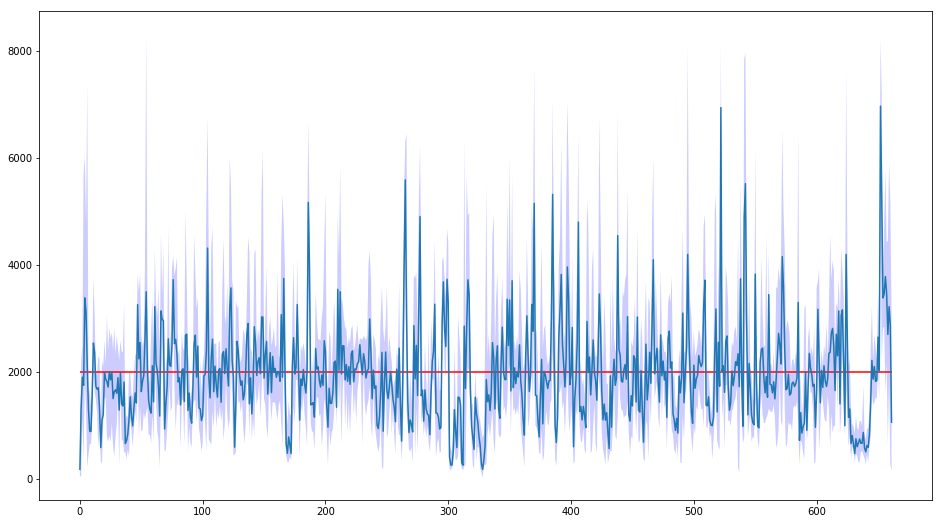

In [3]:
# 再生時間順のビットレートの推移をプロット
plt.figure(figsize=(16,9))
#dfc=dfc.sort_values(("Kbps", "mean")).reset_index()
#x = dfc.reset_index()["10sec"].values
x=list(range(len(dfc)))
plt.fill_between(x, dfc[("Kbps", "min")].values, dfc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
plt.plot(dfc[("Kbps", "mean")].values)
plt.hlines(avgbitrate, x[0], x[-1], colors='red')
plt.show()

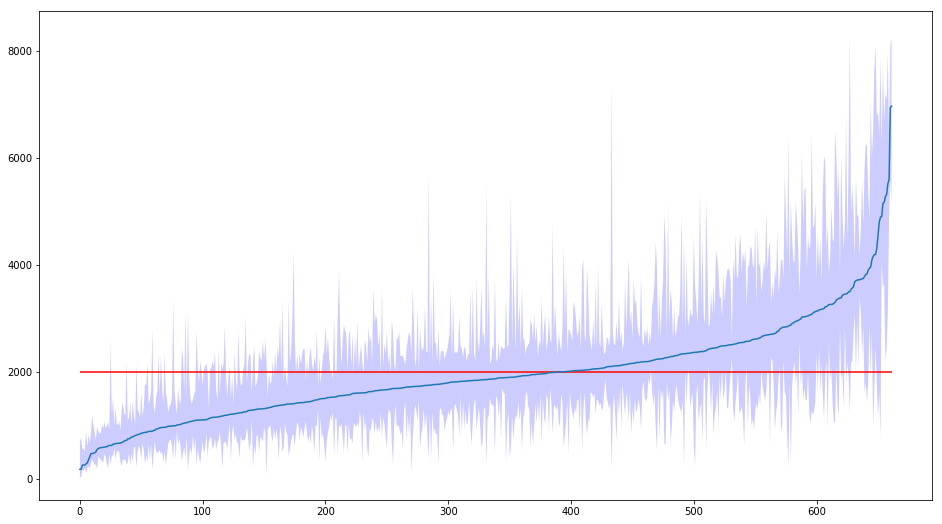

In [4]:
# X軸をビットレート順にした場合のビットレートの分布をプロット
plt.figure(figsize=(16,9))
dfcc=dfc.sort_values(("Kbps", "mean")).reset_index()
#x = dfc.reset_index()["10sec"].values
x=list(range(len(dfcc)))
plt.fill_between(x, dfcc[("Kbps", "min")].values, dfcc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
plt.plot(dfcc[("Kbps", "mean")].values)
plt.hlines(2000, x[0], x[-1], colors='red')
plt.show()

In [5]:
# SSIM類似度の算出
if not os.path.exists(tgtfn+".ssim.log") or forcereload:
    cmdline = ["/usr/bin/ffmpeg", "-threads", "4", "-i", srcfn, "-i", tgtfn, "-filter_complex", "ssim="+tgtfn+".ssim.log", "-an", "-f", "null", "-"]
    subprocess.call(cmdline)
retar=[]
with open(tgtfn+".ssim.log") as fh:
    for idx, line in enumerate(fh):
        ar = line.rstrip().split()
        #print(ar)
        retar.append({
            "idx": int(idx),
            "sec": int(idx/29.97),
            "ssim": float(ar[4][4:])
        })
        #if idx>60:
        #    break
dfd = pd.DataFrame(retar)
dfe = dfd.groupby("sec").agg({"ssim": "mean"}).reset_index()
dfe["10sec"]=dfe["sec"]/10
dfe["10sec"]=dfe["10sec"].astype(int)
dff = dfe.groupby("10sec").agg({"ssim": ['mean']})
#display(dfb)

<Figure size 1152x648 with 0 Axes>

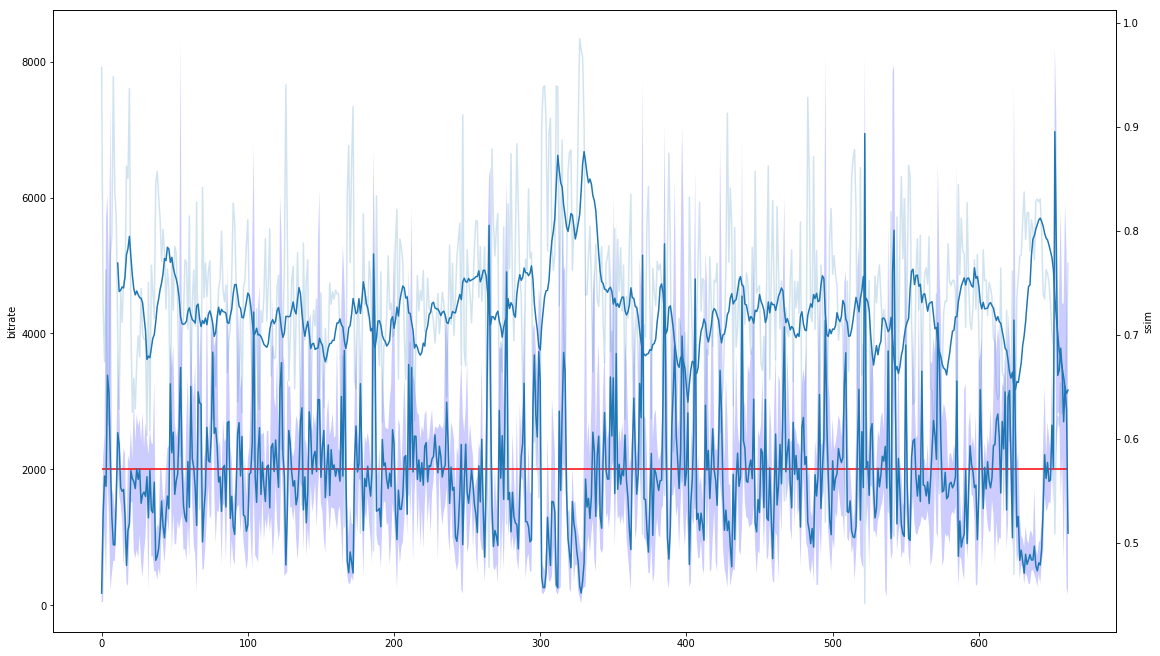

In [6]:
# 再生時間順のビットレートの推移をプロット
dfff = dff[("ssim", "mean")].rolling(12).mean()
plt.figure(figsize=(16,9))
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))
##dfc=dfc.sort_values(("Kbps", "mean")).reset_index()
##x = dfc.reset_index()["10sec"].values
#x=list(range(len(dfc)))
ax.set_ylabel('bitrate')
ax.fill_between(x, dfc[("Kbps", "min")].values, dfc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
ax.plot(dfc[("Kbps", "mean")].values)
ax.hlines(avgbitrate, x[0], x[-1], colors='red')
ax2 = ax.twinx()
ax2.set_ylabel('ssim')
ax2.plot(dff[("ssim", "mean")].values, alpha=0.2)
ax2.plot(dfff.values, color='#1f77b4')
plt.show()

<Figure size 1152x648 with 0 Axes>

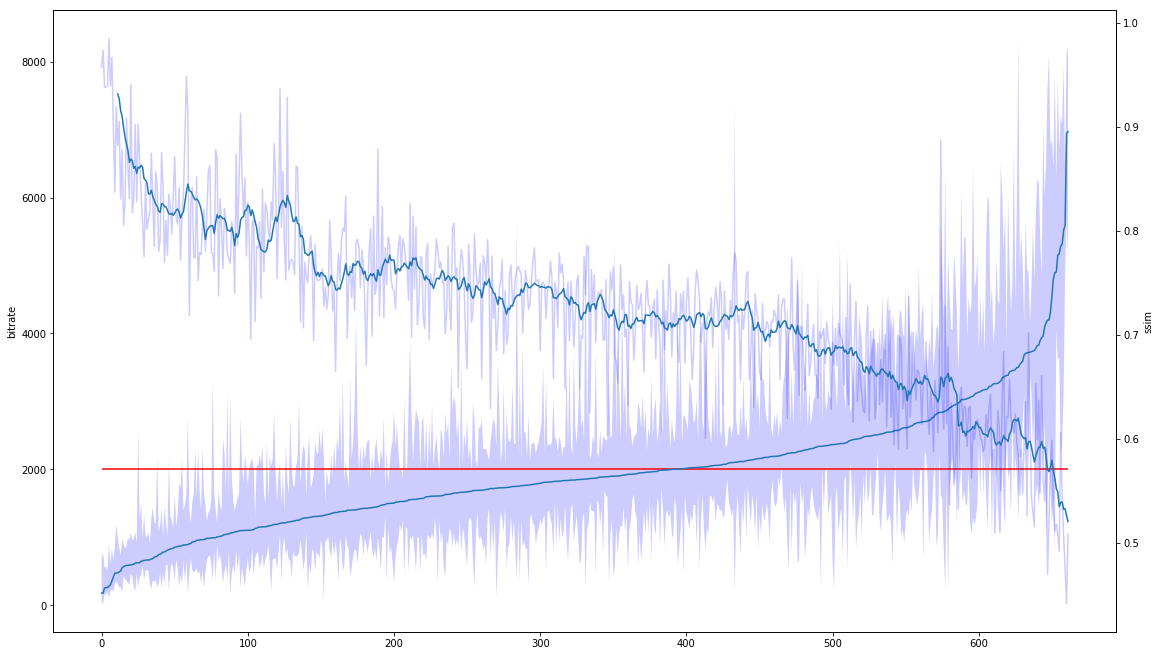

In [7]:
dfg = pd.concat([dfc, dff], axis=1).sort_values(("Kbps", "mean")).reset_index()
dfgg = dfg[("ssim", "mean")].rolling(12).mean()
x=list(range(len(dfg)))

plt.figure(figsize=(16,9))
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

ax.set_ylabel('bitrate')
ax.fill_between(x, dfg[("Kbps", "min")].values, dfg[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
ax.plot(dfg[("Kbps", "mean")].values)
ax.hlines(avgbitrate, x[0], x[-1], colors='red')
ax2 = ax.twinx()
ax2.set_ylabel('ssim')
ax2.plot(dfg[("ssim", "mean")].values, color='blue', alpha=0.2)
ax2.plot(dfgg.values)
plt.show()

encoded with hevc_nvenc

```shell
ffmpeg -i test_rugby_source.ts -c:v hevc_nvenc -b:v 2000k -preset slow -c:a aac -b:a 144k -ac 2 test_rugby_nvenc-2000k.mp4
```

In [8]:
srcfn = "/home/kiuchi/test_rugby_source.ts"
tgtfn = '/home/kiuchi/test_rugby_nvenc-1000k.mp4'
avgbitrate=2000 # Kbps
forcereload = False

In [9]:
# 1秒ごと, 10秒ごとのビットレート推移を取得
if not os.path.exists(tgtfn+".log") or forcereload:
    cmdstr = ["/usr/bin/ffprobe", "-select_streams", "v", "-show_entries", "frame=pkt_size,pkt_pts_time", tgtfn]
    fh = open(tgtfn+".log", "w")
    p = subprocess.Popen(cmdstr, stdout=subprocess.PIPE)
    fh.write(p.communicate()[0].decode("utf-8", "ignore"))
    fh.close()
    os.sync()

infodict = []
with open(tgtfn+".log") as fh:
    for line in fh:
        line = line.rstrip()
        if re.match(r'pkt_pts_time=', line) != None:
            #print(line[re.match(r'pkt_pts_time=', line).end():])
            time = float(line[re.match(r'pkt_pts_time=', line).end():])
        if re.match(r'pkt_size=', line) != None:
            #print(line[re.match(r'pkt_size=', line).end():])
            size = float(line[re.match(r'pkt_size=', line).end():])
        if re.match(r'\[/FRAME\]', line) != None:
            #print("{0:10.03f}: {1:10.03f}".format(time, size))
            infodict.append({"time": time, "size": size})

df_b = pd.DataFrame(infodict)
df_b["sec"] = df_b["time"].astype(int)
df_bb = df_b.groupby("sec").agg({"size": ['sum']}).reset_index()
df_bb["Kbps"]=df_bb[("size","sum")]*8/1024
df_bb["10sec"]=df_bb["sec"]/10
df_bb["10sec"]=df_bb["10sec"].astype(int)
df_bc = df_bb.groupby("10sec").agg({"Kbps": ['mean', 'min', 'max']})

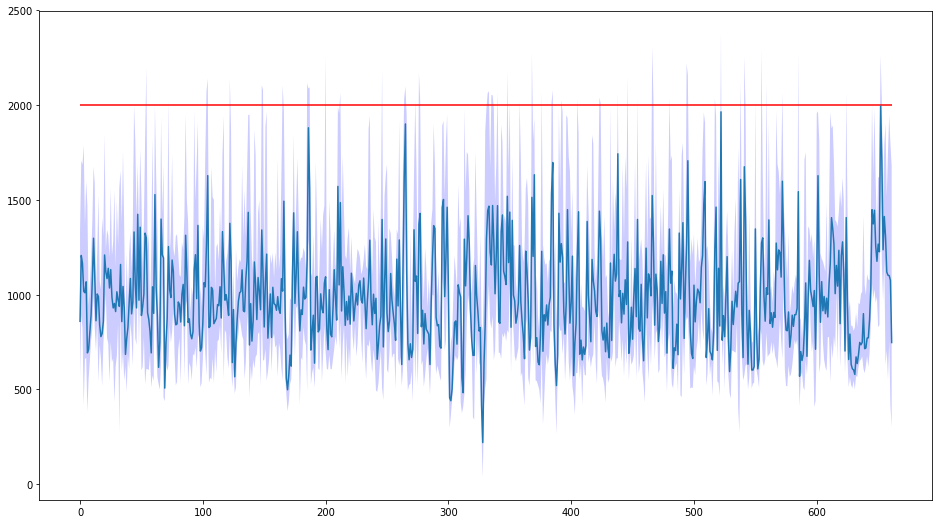

In [10]:
# 再生時間順のビットレートの推移をプロット
plt.figure(figsize=(16,9))
#dfc=dfc.sort_values(("Kbps", "mean")).reset_index()
#x = dfc.reset_index()["10sec"].values
x=list(range(len(df_bc)))
plt.fill_between(x, df_bc[("Kbps", "min")].values, df_bc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
plt.plot(df_bc[("Kbps", "mean")].values)
plt.hlines(avgbitrate, x[0], x[-1], colors='red')
plt.show()

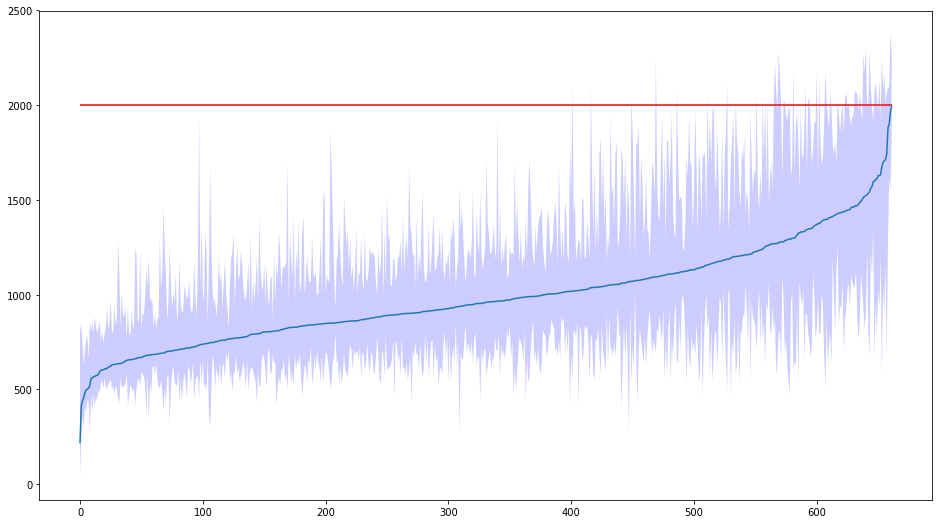

In [11]:
# X軸をビットレート順にした場合のビットレートの分布をプロット
plt.figure(figsize=(16,9))
df_bcc=df_bc.sort_values(("Kbps", "mean")).reset_index()
#x = dfc.reset_index()["10sec"].values
x=list(range(len(df_bcc)))
plt.fill_between(x, df_bcc[("Kbps", "min")].values, df_bcc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
plt.plot(df_bcc[("Kbps", "mean")].values)
plt.hlines(2000, x[0], x[-1], colors='red')
plt.show()

In [15]:
# SSIM類似度の算出
if not os.path.exists(tgtfn+".ssim.log") or forcereload:
    cmdline = ["/usr/bin/ffmpeg", "-threads", "4", "-i", srcfn, "-i", tgtfn, "-filter_complex", "ssim="+tgtfn+".ssim.log", "-an", "-f", "null", "-"]
    subprocess.call(cmdline)
retar=[]
with open(tgtfn+".ssim.log") as fh:
    for idx, line in enumerate(fh):
        ar = line.rstrip().split()
        #print(ar)
        retar.append({
            "idx": int(idx),
            "sec": int(idx/29.97),
            "ssim": float(ar[4][4:])
        })
        #if idx>60:
        #    break
df_bd = pd.DataFrame(retar)
df_be = df_bd.groupby("sec").agg({"ssim": "mean"}).reset_index()
df_be["10sec"]=df_be["sec"]/10
df_be["10sec"]=df_be["10sec"].astype(int)
df_bf = df_be.groupby("10sec").agg({"ssim": ['mean']})
#display(dfb)

<Figure size 1152x648 with 0 Axes>

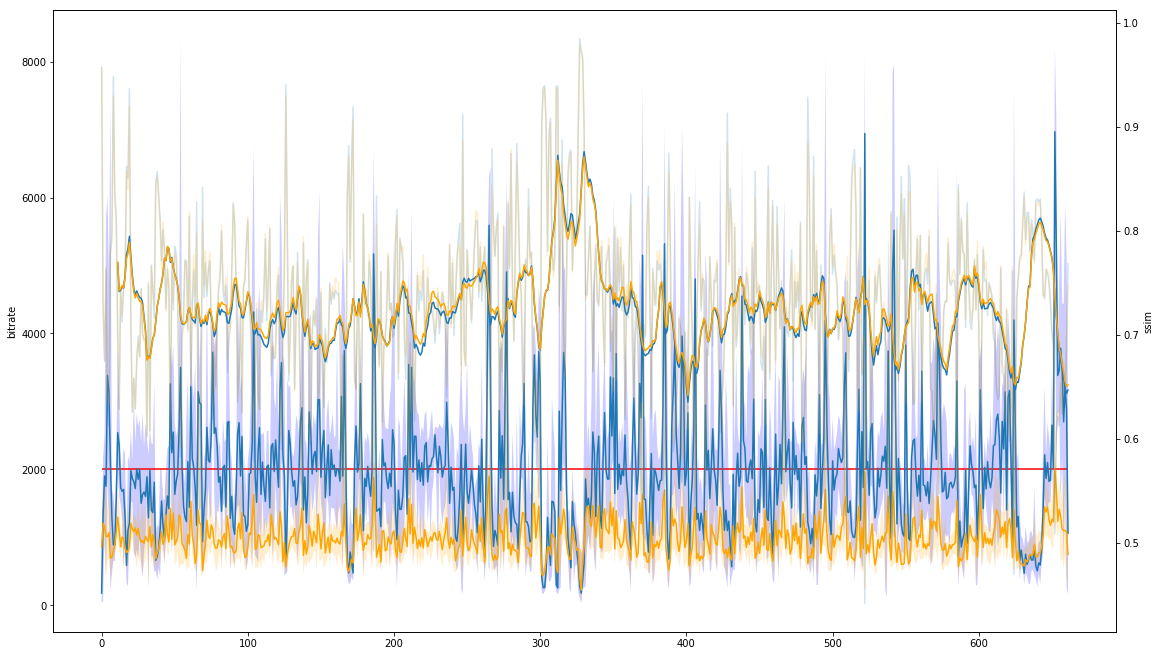

In [16]:
# 再生時間順のビットレートの推移をプロット
dfff = dff[("ssim", "mean")].rolling(12).mean()
df_bff = df_bf[("ssim", "mean")].rolling(12).mean()
plt.figure(figsize=(16,9))
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))
##dfc=dfc.sort_values(("Kbps", "mean")).reset_index()
##x = dfc.reset_index()["10sec"].values
#x=list(range(len(dfc)))
# ビットレートの推移 - ベースライン(青)と比較対象(オレンジ)
ax.set_ylabel('bitrate')
ax.fill_between(x, dfc[("Kbps", "min")].values, dfc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
ax.fill_between(x, df_bc[("Kbps", "min")].values, df_bc[("Kbps", "max")].values, facecolor='orange', linewidth=0, alpha=0.2)
ax.plot(dfc[("Kbps", "mean")].values)
ax.plot(df_bc[("Kbps", "mean")].values, color='orange')
ax.hlines(avgbitrate, x[0], x[-1], colors='red')
# SSIMの推移 - ベースライン(青)と比較対象(オレンジ)
ax2 = ax.twinx()
ax2.set_ylabel('ssim')
ax2.plot(dff[("ssim", "mean")].values, alpha=0.2)
ax2.plot(df_bf[("ssim", "mean")].values, color='orange', alpha=0.2)
ax2.plot(dfff.values, color='#1f77b4')
ax2.plot(df_bff.values, color='orange')
plt.show()

<Figure size 1152x648 with 0 Axes>

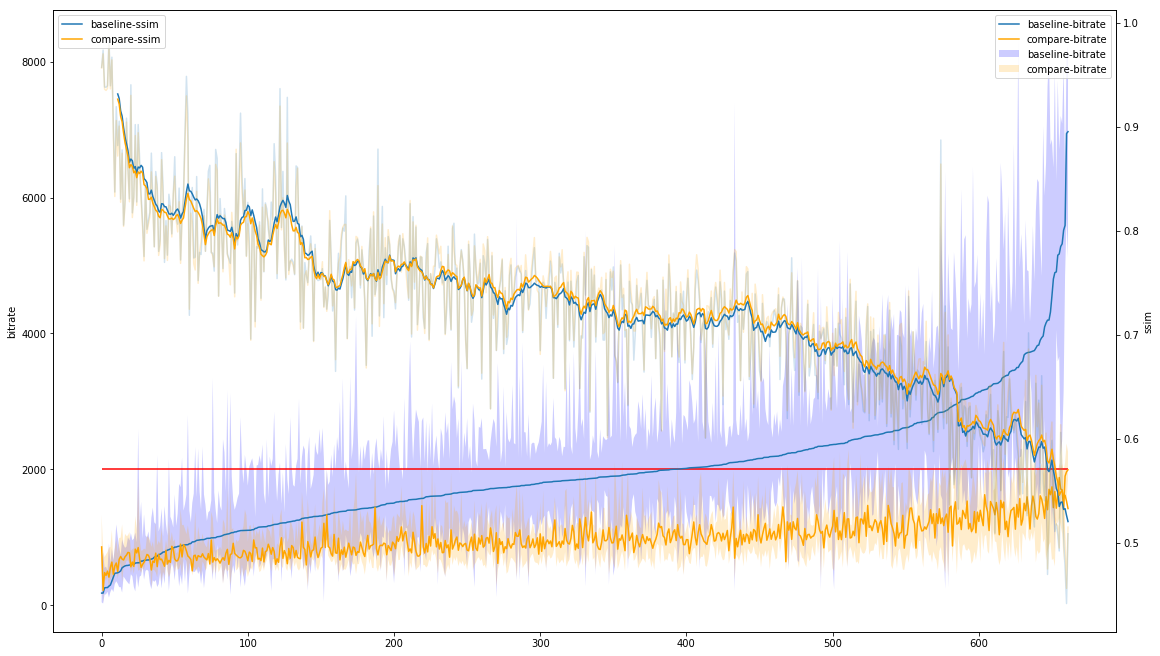

In [17]:
#display(dfc.rename(columns={"Kbps": "grapha"}, level=0).loc[:5, :])
#display(df_bc.loc[:5, :])
dfh = pd.concat(
    [
        dfc.rename(columns={"Kbps": "grapha"}, level=0),
        df_bc.rename(columns={"Kbps": "graphb"}, level=0),
        dff.rename(columns={"ssim": "grapha"}, level=0).rename(columns={"mean": "ssim"}, level=1),
        df_bf.rename(columns={"ssim": "graphb"}, level=0).rename(columns={"mean": "ssim"}, level=1),
    ],
    axis=1)
dfh = dfh.sort_values(("grapha", "mean")).reset_index()
dfh_ga_ssim_ra = dfh[("grapha", "ssim")].rolling(12).mean()
dfh_gb_ssim_ra = dfh[("graphb", "ssim")].rolling(12).mean()
#display(dfh.loc[:5, :])
x=list(range(len(dfh)))

plt.figure(figsize=(16,9))
fig, ax = plt.subplots(constrained_layout=True, figsize=(16,9))

ax.set_ylabel('bitrate')
ax.fill_between(x, dfh[("grapha", "min")].values, dfh[("grapha", "max")].values, facecolor='blue', linewidth=0, alpha=0.2, label='baseline-bitrate')
ax.fill_between(x, dfh[("graphb", "min")].values, dfh[("graphb", "max")].values, facecolor='orange', linewidth=0, alpha=0.2, label='compare-bitrate')
ax.plot(dfh[("grapha", "mean")].values, color='#1f77b4', label='baseline-bitrate')
ax.plot(dfh[("graphb", "mean")].values, color='orange', label='compare-bitrate')
ax.hlines(avgbitrate, x[0], x[-1], colors='red')
ax.legend(loc=1)
ax2 = ax.twinx()
ax2.set_ylabel('ssim')
ax2.plot(dfh[("grapha", "ssim")].values, color='#1f77b4', alpha=0.2)
ax2.plot(dfh[("graphb", "ssim")].values, color='orange', alpha=0.2)
ax2.plot(dfh_ga_ssim_ra, color='#1f77b4', label='baseline-ssim')
ax2.plot(dfh_gb_ssim_ra, color='orange', label='compare-ssim')
#ax2.plot(dfgg.values)
ax2.legend(loc=2)
plt.show()